In [0]:
import random
from pathlib import Path
import os
import numpy as np
import matplotlib.pyplot as plt
from collections import defaultdict
import collections
from shutil import copy
from shutil import copytree, rmtree
import random
from tqdm import tqdm_notebook as tqdm
import math
import time
from IPython.core.debugger import set_trace

In [0]:
# pytorch imports
import torch
import torchvision
from torchvision import models, transforms, datasets
from torch.utils.data import DataLoader
from torch import nn
from torch import optim
from torch.utils import data
from torch.autograd import Variable

In [0]:
# from google.colab import drive
# drive.mount('/content/drive')

In [0]:
# !cp -r "/content/drive/My Drive/fynd" ./ && ls fynd/train/

In [0]:
fynd_stats = [(0.7843, 0.7677, 0.7611), (0.3087, 0.3198, 0.3239)]
n_train = 1724 # train:valid -> 80:20
bs = 32

In [5]:
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
gpu = True if torch.cuda.is_available() else False
gpu

True

In [6]:
fynd_path = Path('fynd/')
TRAIN_PATH = Path('fynd/train/')
MODEL_PATH = 'model_data/'
fynd_path, TRAIN_PATH, MODEL_PATH

(PosixPath('fynd'), PosixPath('fynd/train'), 'model_data/')

In [0]:
os.makedirs(MODEL_PATH, exist_ok=True)

## Helpers

In [0]:
def pp_(*args, n_dash=120):
    for arg in args:
        print(arg)
        print("-"*n_dash)

In [0]:
def save_checkpoint(model, is_best, filename='model_data/checkpoint.pth'):
    """Save checkpoint if a new best is achieved"""
    if is_best:
        torch.save(model.state_dict(), filename)  # save checkpoint
    else:
        print ("=> Validation Accuracy did not improve")
        
# from fastai library
def load_checkpoint(model, filename = 'model_data/checkpoint.pth'):
    sd = torch.load(filename, map_location=lambda storage, loc: storage)
    names = set(model.state_dict().keys())
    for n in list(sd.keys()): 
        if n not in names and n+'_raw' in names:
            if n+'_raw' not in sd: sd[n+'_raw'] = sd[n]
            del sd[n]
    model.load_state_dict(sd)        

In [0]:
def save_model(model, path):
    torch.save(model.state_dict(), path)
    
def load_model(model, path):
    model.load_state_dict(torch.load(path))    

In [0]:
def calc_iters(dataset, num_epochs, bs):
    return int(len(dataset) * num_epochs /bs)

In [0]:
def accuracy(output, target, is_test=False):
    global total
    global correct
    batch_size = output.shape[0]
    total += batch_size
    
    _, pred = torch.max(output, 1)
    if is_test:
        preds.extend(pred)
    correct += (pred == target).sum()
    return 100 * correct / total

In [0]:
class AvgStats(object):
    def __init__(self):
        self.reset()
        
    def reset(self):
        self.losses =[]
        self.precs =[]
        self.its = []
        
    def append(self, loss, prec, it):
        self.losses.append(loss)
        self.precs.append(prec)
        self.its.append(it)


In [0]:
def freeze(model):
    child_counter = 0
    for name, child in model.named_children():
        if child_counter < 7:
            print("name ",name, "child ",child_counter," was frozen")
            for param in child.parameters():
                param.requires_grad = False
        elif child_counter == 7:
            children_of_child_counter = 0
            for children_of_child in child.children():
                if children_of_child_counter < 2:
                    for param in children_of_child.parameters():
                        param.requires_grad = False
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was frozen')
                else:
                    print("name ",name, 'child ', children_of_child_counter, 'of child',child_counter,' was not frozen')
                children_of_child_counter += 1

        else:
            print("name ",name, "child ",child_counter," was not frozen")
        child_counter += 1

In [0]:
def unfreeze(model):
    for param in model.parameters():
        param.requires_grad = True


In [0]:
def print_frozen_state(model):
    child_counter = 0
    for name, child in model.named_children():
        for param in child.parameters():
            if param.requires_grad == True:
                print("child ",child_counter,"named:",name," is unfrezed")
            elif param.requires_grad == False:
                print("child ",child_counter,"named:",name," is frezed")
        child_counter += 1

In [0]:
def update_lr(optimizer, lr):
    for g in optimizer.param_groups:
        g['lr'] = lr

In [0]:
def update_mom(optimizer, mom):
    for g in optimizer.param_groups:
        g['momentum'] = mom

## Dataset Preparation

In [0]:
class Fynd_Foot():
    def __init__(self):
        self.train_ds, self.valid_ds, self.train_cls, self.valid_cls = [None]*4
        self.mean = fynd_stats[0]
        self.std = fynd_stats[1]

    def _get_tfms(self):
        train_tfms = transforms.Compose([
              transforms.RandomResizedCrop(224),
              transforms.ToTensor(),
              transforms.Normalize(self.mean, self.std)])

        valid_tfms = transforms.Compose([
            transforms.RandomResizedCrop(224),
            transforms.ToTensor(),
            transforms.Normalize(self.mean, self.std)])        
        return train_tfms, valid_tfms            

    def get_dataset(self,root_dir='./fynd/'):
        train_tfms, valid_tfms = self._get_tfms() # transformations
        self.ds = datasets.ImageFolder(root=TRAIN_PATH, transform=train_tfms)

        idx = list(range(len(self.ds)))  # indices to all elements
        random.shuffle(idx)  # in-place shuffle the indices to facilitate random splitting
        train_idx = idx[:n_train]
        val_idx = idx[n_train:]
        self.train_ds = data.Subset(self.ds, train_idx)
        self.valid_ds = data.Subset(self.ds, val_idx)
        self.train_classes = self.train_ds.dataset.classes
        self.valid_classes = self.valid_ds.dataset.classes

        assert self.train_classes==self.valid_classes
        return self.train_ds, self.valid_ds, self.train_classes


    def get_dls(self, train_ds, valid_ds, bs, **kwargs):
        return (DataLoader(train_ds, batch_size=bs, shuffle=True, **kwargs),
               DataLoader(valid_ds, batch_size=bs, shuffle=False, **kwargs))

ff = Fynd_Foot()

In [20]:
train_ds, valid_ds, classes =  ff.get_dataset()
num_classes = len(classes)
pp_(len(train_ds),train_ds.dataset.classes, len(valid_ds),valid_ds.dataset.classes, num_classes)

1724
------------------------------------------------------------------------------------------------------------------------
['backstrap', 'buckle', 'hook&look', 'lace_up', 'slip_on', 'zipper']
------------------------------------------------------------------------------------------------------------------------
431
------------------------------------------------------------------------------------------------------------------------
['backstrap', 'buckle', 'hook&look', 'lace_up', 'slip_on', 'zipper']
------------------------------------------------------------------------------------------------------------------------
6
------------------------------------------------------------------------------------------------------------------------


In [0]:
train_dl, valid_dl = ff.get_dls(train_ds, valid_ds, bs=bs, num_workers=2)

In [0]:
# Wrap all inside databunch
class DataBunch():
    def __init__(self, train_dl, valid_dl, c=None):
        self.train_dl, self.valid_dl, self.c = train_dl, valid_dl, c
    
    @property
    def train_ds(self): return self.train_dl.dataset
    
    @property
    def valid_ds(self): return self.valid_dl.dataset
    
    def __repr__(self):
        return str(self.__class__.__name__)+" obj (train & valid DataLoaders)"

In [0]:
data = DataBunch(train_dl, valid_dl, c=num_classes)

In [24]:
pp_(len(data.train_ds), data.c, len(data.valid_ds))

1724
------------------------------------------------------------------------------------------------------------------------
6
------------------------------------------------------------------------------------------------------------------------
431
------------------------------------------------------------------------------------------------------------------------



Visualize random image from each of the 6 classes

In [0]:
# This can be used to print predictions too
def show_ds(trainset, classes, validset=None, cols=5, rows=5, preds=None, is_pred=False, is_valid=False):        
    fig = plt.figure(figsize=(20,20))
    fig.suptitle(f"Showing one random image from each {'Validation' if is_valid else 'Train'} classes", y=0.92, fontsize=24) # Adding  y=1.05, fontsize=24 helped me fix the suptitle overlapping with axes issue
    columns = cols
    rows = rows
    mean = fynd_stats[0]
    std = fynd_stats[1]  

    for i in range(1, columns*rows +1):
        fig.add_subplot(rows, columns, i)
        
        if is_pred and testset:
            img_xy = np.random.randint(len(testset));
            np_img = testset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))            
            img = img * std + mean
        else:
            img_xy = np.random.randint(len(trainset));
            np_img = trainset[img_xy][0].numpy()
            img = np.transpose(np_img, (1,2,0))
            img = img * std + mean
        
        if is_pred:
            plt.title(classes[int(preds[img_xy])] + "/" + classes[testset[img_xy][1]])
        else:
            plt.title(classes[trainset[img_xy][1]])
        plt.axis('off')
        img = np.clip(img, 0, 1)
        plt.imshow(img, interpolation='nearest')
    plt.show()

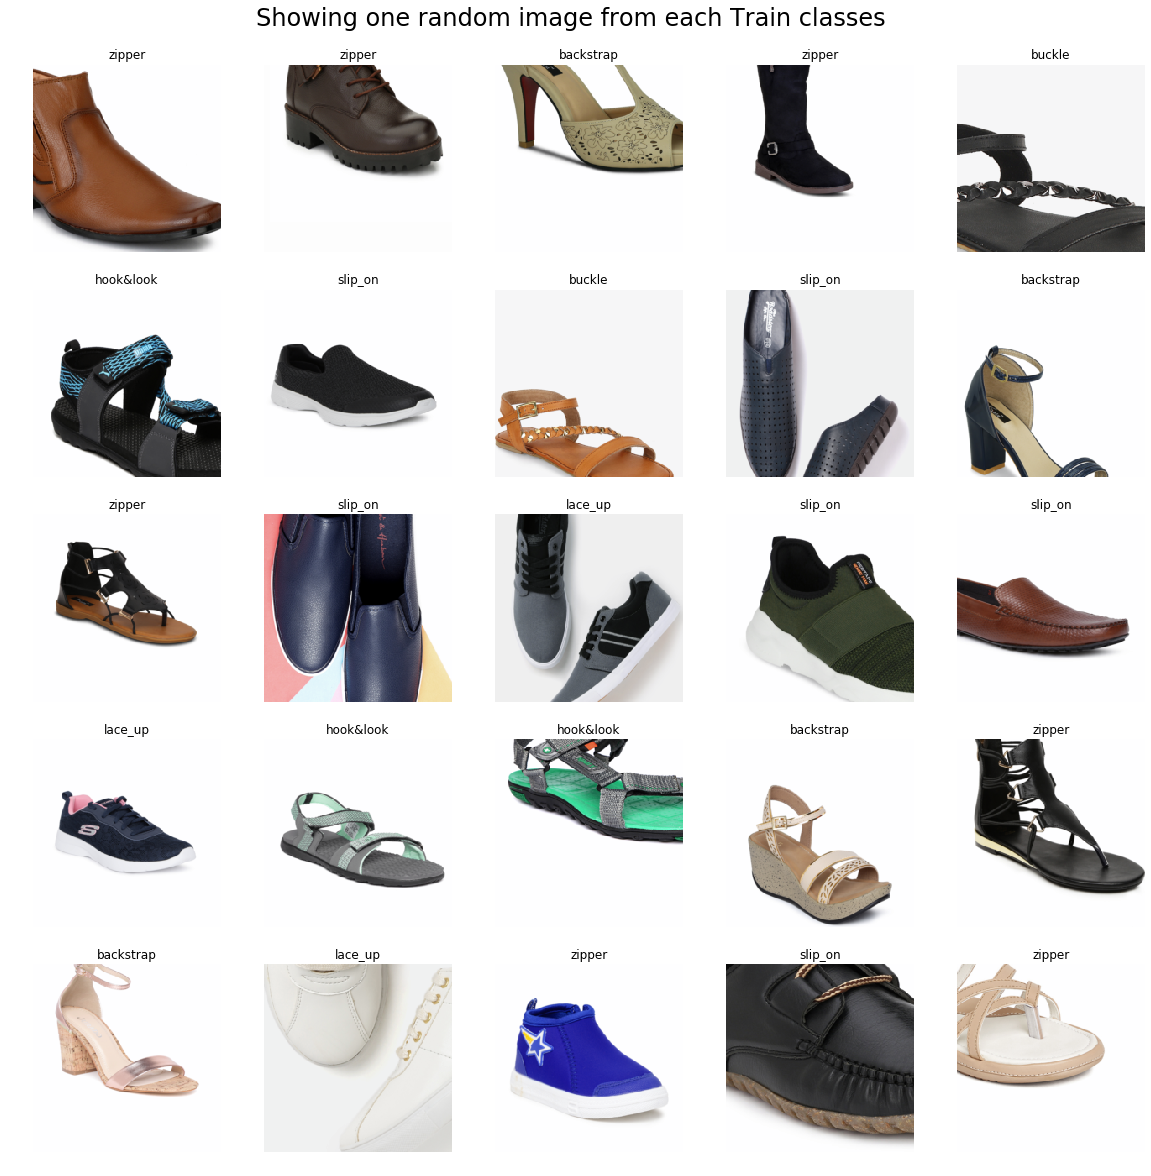

In [84]:
show_ds(data.train_ds, classes)

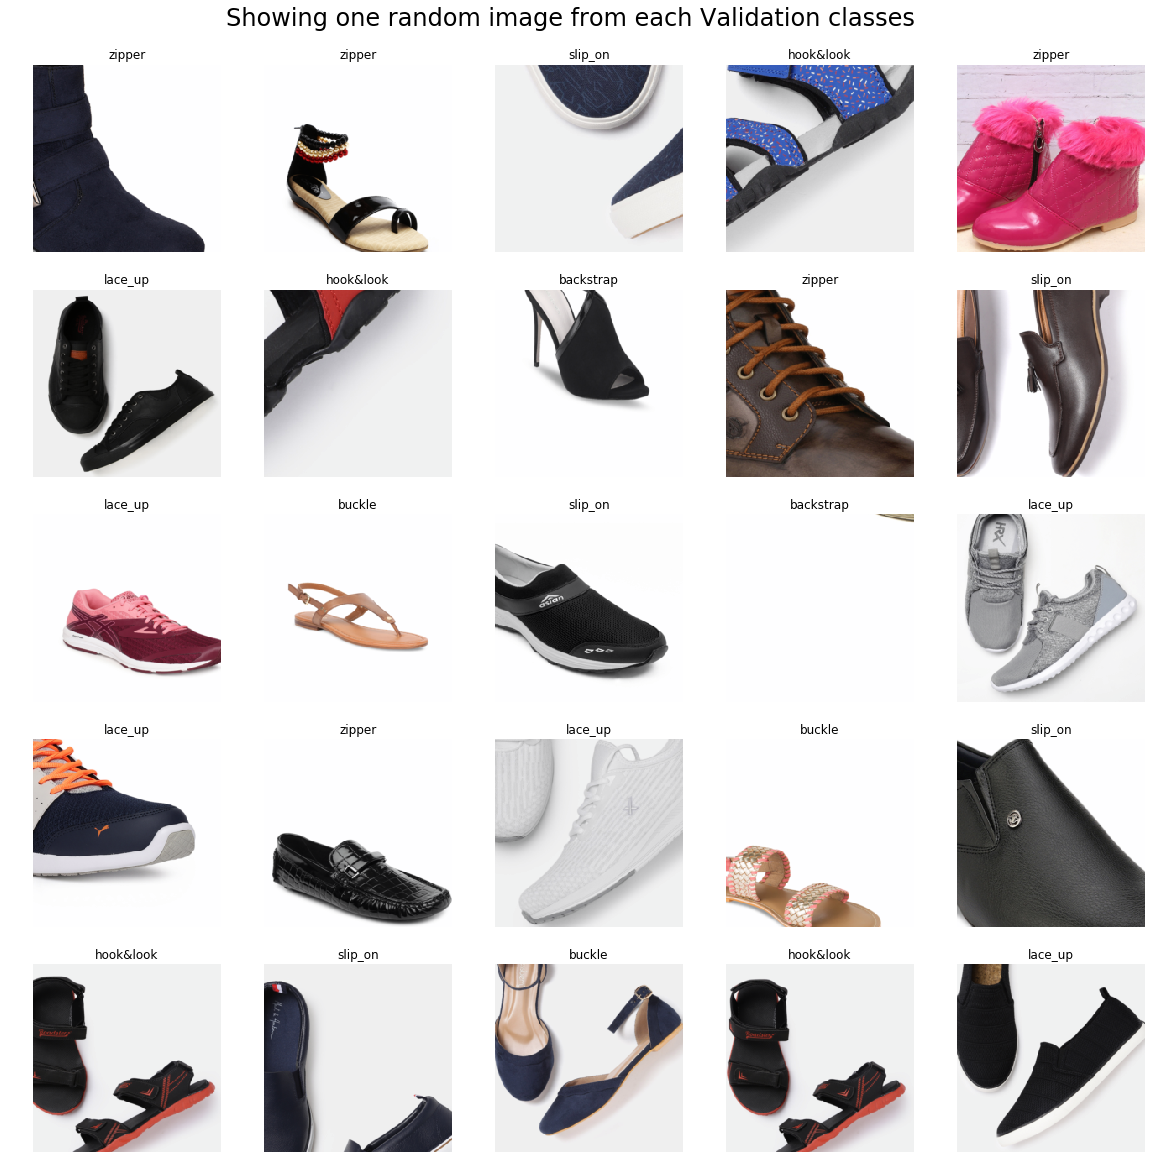

In [85]:
show_ds(data.valid_ds, classes, is_valid=True)


# Training
## Define Model, Optimizer and Loss Function
We will be using resnet-50,
SGD optimizer,
& CrossEntropy Loss


In [0]:
loss_func=nn.CrossEntropyLoss()

In [0]:
def get_model(lr=3e-3,num_classes=num_classes, opt="SGD", **kwargs):
    model_imgnet = models.resnet50(pretrained=True) # model
    num_ftrs = model_imgnet.fc.in_features
    model_imgnet.fc = nn.Linear(in_features=num_ftrs, out_features=num_classes, bias=True)
    model = model_imgnet.to(device)
#     print(model)
    if opt=="SGD":
        return model, optim.SGD(model.parameters(), lr=lr, **kwargs)
    elif opt=="Adam":
        return model, optim.Adam(model.parameters(), lr=lr, **kwargs)
    else:
        return model, optim.RMSprop(model.parameters(), lr=lr, **kwargs)

In [0]:
class Learner():
    """
    stores Model, Optimizer, Loss Function and Datasets (train & valid)
    """
    def __init__(self, model, opt, loss_func, data ):
        self.model, self.opt, self.loss_func, self.data = model, opt, loss_func, data


In [0]:
learn = Learner(*get_model(momentum=0.9, weight_decay=1e-4, nesterov=True), loss_func, data)

In [0]:
learn.loss_func = nn.CrossEntropyLoss()
learn.opt = torch.optim.SGD(learn.model.parameters(), lr=1e-4, momentum=0.95, weight_decay=1e-4)

In [31]:
pp_(learn.data, learn.loss_func, learn.opt) #, learn.model)

DataBunch obj (train & valid DataLoaders)
------------------------------------------------------------------------------------------------------------------------
CrossEntropyLoss()
------------------------------------------------------------------------------------------------------------------------
SGD (
Parameter Group 0
    dampening: 0
    lr: 0.0001
    momentum: 0.95
    nesterov: False
    weight_decay: 0.0001
)
------------------------------------------------------------------------------------------------------------------------



### The approach is :

    first find the optimal Learnng rate for the freezed model using LR finder (cyclical learning rates) plot. Train the freezed pretrained model (e.g. resnet-50) for a few epochs with learning_rate= optimal L.R. (from lr finder) using 1-cycle-policy.

    next, unfreeze the model and find optimal learning rate using LR finder (cyclical learning rates) plot.

    finally train the unfreezed model using the optimal L.R. (found from L.R. finder) using 1-cycle-policy for some more epochs

Freeze all layers except last 4 layers:


In [32]:
freeze(learn.model)

name  conv1 child  0  was frozen
name  bn1 child  1  was frozen
name  relu child  2  was frozen
name  maxpool child  3  was frozen
name  layer1 child  4  was frozen
name  layer2 child  5  was frozen
name  layer3 child  6  was frozen
name  layer4 child  0 of child 7  was frozen
name  layer4 child  1 of child 7  was frozen
name  layer4 child  2 of child 7  was not frozen
name  avgpool child  8  was not frozen
name  fc child  9  was not frozen



## One Cycle Policy

In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during whole run with 2 steps of equal length. During first step, increase the learning rate from lower learning rate to higher learning rate. And in second step, decrease it from higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one addition to this. - During last few hundred/thousand iterations of cycle reduce the learning rate to 1/100th or 1/1000th of the lower learning rate.

Also, Author suggests that reducing momentum when learning rate is increasing. So, we make one cycle of momentum also with learning rate - Decrease momentum when learning rate is increasing and increase momentum when learning rate is decreasing.

reference: https://github.com/nachiket273/One_Cycle_Policy

In [0]:
class OneCycle(object):
    """
    In paper (https://arxiv.org/pdf/1803.09820.pdf), author suggests to do one cycle during 
    whole run with 2 steps of equal length. During first step, increase the learning rate 
    from lower learning rate to higher learning rate. And in second step, decrease it from 
    higher to lower learning rate. This is Cyclic learning rate policy. Author suggests one 
    addition to this. - During last few hundred/thousand iterations of cycle reduce the 
    learning rate to 1/100th or 1/1000th of the lower learning rate.

    Also, Author suggests that reducing momentum when learning rate is increasing. So, we make 
    one cycle of momentum also with learning rate - Decrease momentum when learning rate is 
    increasing and increase momentum when learning rate is decreasing.

    Args:
        nb              Total number of iterations including all epochs

        max_lr          The optimum learning rate. This learning rate will be used as highest 
                        learning rate. The learning rate will fluctuate between max_lr to
                        max_lr/div and then (max_lr/div)/div.

        momentum_vals   The maximum and minimum momentum values between which momentum will
                        fluctuate during cycle.
                        Default values are (0.95, 0.85)

        prcnt           The percentage of cycle length for which we annihilate learning rate
                        way below the lower learnig rate.
                        The default value is 10

        div             The division factor used to get lower boundary of learning rate. This
                        will be used with max_lr value to decide lower learning rate boundary.
                        This value is also used to decide how much we annihilate the learning 
                        rate below lower learning rate.
                        The default value is 10.
    """
    def __init__(self, nb, max_lr, momentum_vals=(0.95, 0.85), prcnt= 10 , div=10):
        self.nb = nb
        self.div = div
        self.step_len =  int(self.nb * (1- prcnt/100)/2)
        self.high_lr = max_lr
        self.low_mom = momentum_vals[1]
        self.high_mom = momentum_vals[0]
        self.prcnt = prcnt
        self.iteration = 0
        self.lrs = []
        self.moms = []
        
    def calc(self):
        self.iteration += 1
        lr = self.calc_lr()
        mom = self.calc_mom()
        return (lr, mom)
        
    def calc_lr(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.lrs.append(self.high_lr/self.div)
            return self.high_lr/self.div
        if self.iteration > 2 * self.step_len:
            ratio = (self.iteration - 2 * self.step_len) / (self.nb - 2 * self.step_len)
            lr = self.high_lr * ( 1 - 0.99 * ratio)/self.div
        elif self.iteration > self.step_len:
            ratio = 1- (self.iteration -self.step_len)/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        else :
            ratio = self.iteration/self.step_len
            lr = self.high_lr * (1 + ratio * (self.div - 1)) / self.div
        self.lrs.append(lr)
        return lr
    
    def calc_mom(self):
        if self.iteration==self.nb:
            self.iteration = 0
            self.moms.append(self.high_mom)
            return self.high_mom
        if self.iteration > 2 * self.step_len:
            mom = self.high_mom
        elif self.iteration > self.step_len:
            ratio = (self.iteration -self.step_len)/self.step_len
            mom = self.low_mom + ratio * (self.high_mom - self.low_mom)
        else :
            ratio = self.iteration/self.step_len
            mom = self.high_mom - ratio * (self.high_mom - self.low_mom)
        self.moms.append(mom)
        return mom


Train for a few epochs(3 to 5) using CLR and 1-cycle-policy

In [0]:
total = 0
correct = 0

train_loss = 0
test_loss = 0
best_acc = 0
trn_losses = []
trn_accs = []
val_losses = []
val_accs = []

preds =[]

train_stats = AvgStats()
test_stats = AvgStats()

In [0]:
def train(epoch=0, use_cycle = False, model=learn.model):
    model.train()
    global best_acc
    global trn_accs, trn_losses
    is_improving = True
    counter = 0
    running_loss = 0.
    avg_beta = 0.98
    t1 = tqdm(learn.data.train_dl, leave=False, total=int(len(learn.data.train_dl)))
        
    for i, (input, target) in enumerate(t1):
        bt_start = time.time()
        if gpu :
            input, target = input.cuda(), target.cuda() 
        else :
            input, target = input.cpu(), target.cpu()
        var_ip, var_tg = Variable(input), Variable(target)
                
        if use_cycle:    
            lr, mom = onecycle.calc()
            update_lr(learn.opt, lr)
            update_mom(learn.opt, mom)
            
        output = model(var_ip)
        loss = learn.loss_func(output, var_tg)
            
        running_loss = avg_beta * running_loss + (1-avg_beta) *loss
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        
        trn_losses.append(smoothed_loss)
            
        # measure accuracy and record loss
        prec = accuracy(output.data, target)
        trn_accs.append(prec)

        train_stats.append(smoothed_loss, prec, time.time()-bt_start)
        if prec > best_acc :
            best_acc = prec
            save_checkpoint(model, True)

        # compute gradient and do SGD step
        learn.opt.zero_grad()
        loss.backward()
        learn.opt.step()

In [0]:
def validate(model=learn.model):
    avg_beta = 0.98
    model.eval()
    global val_accs, val_losses
    running_loss = 0.
    t2 = tqdm(learn.data.valid_dl, leave=False, total=int(len(learn.data.valid_dl)))
    with torch.no_grad():
        for i, (input, target) in enumerate(t2):
            bt_start = time.time()
            if gpu :
                input, target = input.cuda(), target.cuda() 
            else :
                input, target = input.cpu(), target.cpu()
            var_ip, var_tg = Variable(input), Variable(target)
            output = model(var_ip)
            loss = learn.loss_func(output, var_tg)

            running_loss = avg_beta * running_loss + (1-avg_beta) *loss
            smoothed_loss = running_loss / (1 - avg_beta**(i+1))

            # measure accuracy and record loss
            prec = accuracy(output.data, target, is_test=True)
            test_stats.append(loss, prec, time.time()-bt_start)

            val_losses.append(smoothed_loss)
            val_accs.append(prec)

In [0]:
def fit(epochs, use_onecycle=False, model=learn.model):
    print(f"{'epoch':5s}{'train_loss':>15s}{'valid_loss':>15s}{'train_acc':>15s}{'valid_acc':>15s}")
    for epoch in tqdm(range(epochs), leave=False):
        train(epoch, use_onecycle, model)
        validate(model)
        print(f"{epoch+1:5}{trn_losses[-1]:15.5f}{val_losses[-1]:15.5f}{trn_accs[-1]:15.5f}{val_accs[-1]:15.5f}")


## Cyclic Learning Rates

We'll use method described in paper : https://arxiv.org/abs/1506.01186 to find out optimum learning rate.
We'll increase the learning rate from lower value per iteration for some iterations till loss starts exploding.
We'll plot loss vs learning rate plot.
We'll then select learning rate that is one power higher than the one where loss is minimum
This value can be used as maximum value in Cyclic Learning Rate policy and minimum learning rate
can be set to 1/3, 1/4th of max value.


In [0]:
import math
import matplotlib.pyplot as plt


class CLR(object):
    """
    The method is described in paper : https://arxiv.org/abs/1506.01186 to find out optimum 
    learning rate. The learning rate is increased from lower value to higher per iteration 
    for some iterations till loss starts exploding.The learning rate one power lower than 
    the one where loss is minimum is chosen as optimum learning rate for training.

    Args:
        optim   Optimizer used in training.

        bn      Total number of iterations used for this test run.
                The learning rate increasing factor is calculated based on this 
                iteration number.

        base_lr The lower boundary for learning rate which will be used as
                initial learning rate during test run. It is adviced to start from
                small learning rate value like 1e-4.
                Default value is 1e-5

        max_lr  The upper boundary for learning rate. This value defines amplitude
                for learning rate increase(max_lr-base_lr). max_lr value may not be 
                reached in test run as loss may explode before reaching max_lr.
                It is adviced to use higher value like 10, 100.
                Default value is 100.

    """
    def __init__(self, learn, base_lr=1e-5, max_lr=100):
        self.base_lr = base_lr
        self.max_lr = max_lr
        self.optim = learn.opt
        self.bn = len(learn.data.train_dl) - 1
        ratio = self.max_lr/self.base_lr
        self.mult = ratio ** (1/self.bn)
        self.best_loss = 1e9
        self.iteration = 0
        self.lrs = []
        self.losses = []
        
    def calc_lr(self, loss):
        self.iteration +=1
        if math.isnan(loss) or loss > 4 * self.best_loss:
            return -1
        if loss < self.best_loss and self.iteration > 1:
            self.best_loss = loss
            
        mult = self.mult ** self.iteration
        lr = self.base_lr * mult
        
        self.lrs.append(lr)
        self.losses.append(loss)
        
        return lr
        
    def plot(self, start=10, end=-5):
        plt.xlabel("Learning Rate")
        plt.ylabel("Losses")
        plt.plot(self.lrs[start:end], self.losses[start:end])
        plt.xscale('log')

In [0]:
def find_LR(clr):
    t = tqdm(learn.data.train_dl, leave=False, total=len(learn.data.train_dl))
    running_loss = 0.
    avg_beta = 0.98
    learn.model.train()
    for i, (input, target) in enumerate(t):
        if gpu :
            input, target = input.cuda(), target.cuda() 
        else :
            input, target = input.cpu(), target.cpu()
        var_ip, var_tg = Variable(input), Variable(target)
        output = learn.model(var_ip)
        loss = learn.loss_func(output, var_tg)

        running_loss = avg_beta * running_loss + (1-avg_beta) *loss
        smoothed_loss = running_loss / (1 - avg_beta**(i+1))
        t.set_postfix(loss=smoothed_loss)

        lr = clr.calc_lr(smoothed_loss)
        if lr == -1 :
            break
        update_lr(learn.opt, lr)   

        # compute gradient and do SGD step
        learn.opt.zero_grad()
        loss.backward()
        learn.opt.step()


1st LR find and train for few epochs

(Skip if doing for 2nd time i.e. resuming the work)


In [40]:
# clr1 = CLR(learn)
# find_LR(clr1)

In [0]:
# save_model(learn.model, MODEL_PATH+"clr1.pth")

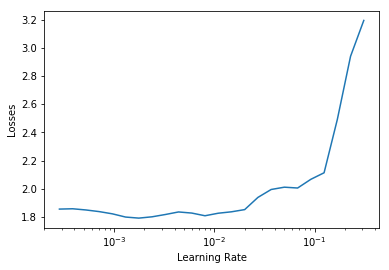

In [41]:
# clr1.plot()

From the LR finder plot, we will use learning rate = 2e-3

In [129]:
# epochs=6
# onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=2e-3, momentum_vals=(0.95, 0.85), prcnt=10)
# fit(epochs, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1       33.27090       17.58098       44.00000       45.00000


    2        9.62359        5.87483       52.00000       53.00000


    3        5.10506        3.62382       57.00000       58.00000


    4        3.03246        3.41463       60.00000       60.00000


    5        2.53196        2.91734       62.00000       62.00000


    6        2.21073        2.79936       63.00000       63.00000


In [0]:
# save_model(learn.model, MODEL_PATH+'stage1_6.pth')

## Clear some gpu memory

In [41]:
!nvidia-smi

Fri Aug  2 13:23:12 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    56W / 149W |   8558MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

In [0]:
del clr1
torch.cuda.empty_cache()

In [43]:
!nvidia-smi

Fri Aug  2 13:23:19 2019       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 418.67       Driver Version: 410.79       CUDA Version: 10.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   33C    P0    56W / 149W |   8244MiB / 11441MiB |      0%      Default |
+-------------------------------+----------------------+----------------------+
                                                                               
+-----------------------------------------------------------------------------+
| Processes:                                                       GPU Memory |
|  GPU  

## Unfreeze & train for longer epochs

Now we will unfreeze the model and again find the optimal lr using Cyclic Learning Rates

In [0]:
load_model(learn.model, MODEL_PATH+'stage1_6.pth')
unfreeze(learn.model)

2nd LR Find: (Skip when doing for 2nd time)

In [44]:
# clr2 = CLR(learn)
# find_LR(clr2)

In [0]:
# save_model(learn.model, MODEL_PATH+"clr2.pth")

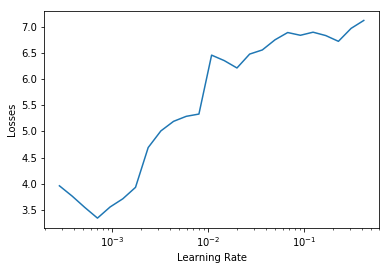

In [50]:
# clr2.plot()

Optimal lr = 2e-4

### Clear gpu mem

In [0]:
# del clr2
# torch.cuda.empty_cache()
# # !nvidia-smi

In [46]:
epochs=10
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=2e-4, momentum_vals=(0.95, 0.85), prcnt=10)
fit(epochs, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1        2.64551        2.94916       69.00000       67.00000


    2        1.65522        1.66295       69.00000       69.00000


    3        1.30469        1.59113       70.00000       71.00000


    4        1.21006        2.06565       72.00000       72.00000


    5        0.89560        1.15311       73.00000       73.00000


    6        0.68502        1.02630       74.00000       74.00000


    7        0.78976        1.06520       75.00000       75.00000


    8        0.64221        0.81490       75.00000       75.00000


    9        0.56369        0.76606       76.00000       76.00000


   10        0.52279        0.90836       77.00000       77.00000


In [0]:
save_model(learn.model, MODEL_PATH+"stage2_10.pth")

In [48]:
epochs=10
onecycle = OneCycle(calc_iters(learn.data.train_ds, epochs, bs), max_lr=2e-4, momentum_vals=(0.95, 0.85), prcnt=10)
fit(epochs, use_onecycle=True, model=learn.model)

epoch     train_loss     valid_loss      train_acc      valid_acc


    1        0.54862        0.81420       77.00000       77.00000


    2        0.61336        0.86318       78.00000       78.00000


    3        0.57054        0.87012       78.00000       78.00000


    4        0.51065        0.68340       79.00000       79.00000


    5        0.45563        0.89182       79.00000       79.00000


    6        0.38604        0.82988       79.00000       79.00000


    7        0.39352        0.73710       80.00000       80.00000


    8        0.36531        0.74658       80.00000       80.00000


    9        0.38298        0.69061       80.00000       80.00000


   10        0.36808        0.72445       81.00000       80.00000


In [0]:
save_model(learn.model, MODEL_PATH+"stage2_20.pth")

## Visualizations

In [0]:
# ref:  https://www.kaggle.com/grfiv4/plot-a-confusion-matrix
import numpy as np


def plot_confusion_matrix(cm,
                          target_names,
                          title='Confusion Matrix',
                          cmap=None,
                          normalize=True):
    """
    given a sklearn confusion matrix (cm), make a nice plot

    Arguments
    ---------
    cm:           confusion matrix from sklearn.metrics.confusion_matrix

    target_names: given classification classes such as [0, 1, 2]
                  the class names, for example: ['high', 'medium', 'low']

    title:        the text to display at the top of the matrix

    cmap:         the gradient of the values displayed from matplotlib.pyplot.cm
                  see http://matplotlib.org/examples/color/colormaps_reference.html
                  plt.get_cmap('jet') or plt.cm.Blues

    normalize:    If False, plot the raw numbers
                  If True, plot the proportions

    Usage
    -----
    plot_confusion_matrix(cm           = cm,                  # confusion matrix created by
                                                              # sklearn.metrics.confusion_matrix
                          normalize    = True,                # show proportions
                          target_names = y_labels_vals,       # list of names of the classes
                          title        = best_estimator_name) # title of graph

    Citiation
    ---------
    http://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html

    """
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")


    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [124]:
# get predictions
y_val, y_pred = [],[]
t2 = tqdm(learn.data.valid_dl, leave=False, total=int(len(learn.data.valid_dl)))
with torch.no_grad():
    for i, (input, target) in enumerate(t2):
        bt_start = time.time()
        if gpu :
            input, target = input.cuda(), target.cuda() 
        else :
            input, target = input.cpu(), target.cpu()
        var_ip, var_tg = Variable(input), Variable(target)
        preds = learn.model(var_ip)
        y_val.append(var_tg.cpu().numpy())
        y_pred.append((torch.argmax(preds, 1)).cpu().numpy())

In [0]:
y_pred = list(np.hstack((x) for x in y_pred))
y_val = list(np.hstack((x) for x in y_val))
# pp_(y_pred, y_val)

In [0]:
from sklearn.metrics import confusion_matrix
cm = confusion_matrix(y_val, y_pred)

In [130]:
cm

array([[53,  4,  1,  0,  3,  4],
       [ 4, 10,  0,  1,  3,  4],
       [ 0,  0, 65,  1,  0,  1],
       [ 0,  0,  0, 85,  4,  2],
       [ 3,  0,  1,  7, 77,  4],
       [ 7,  2,  2,  1,  8, 74]])

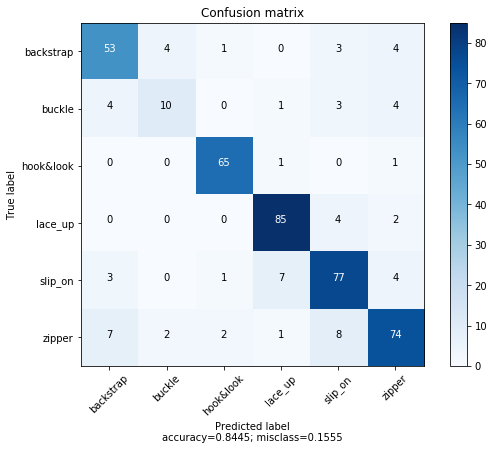

In [131]:
plot_confusion_matrix(cm, target_names=data.valid_ds.dataset.classes, normalize=False)

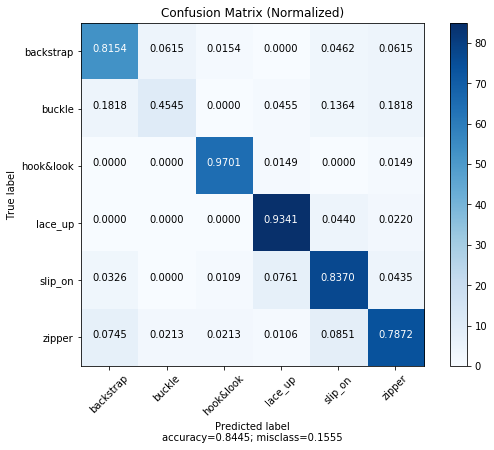

In [134]:
plot_confusion_matrix(cm, target_names=data.valid_ds.dataset.classes, title='Confusion Matrix (Normalized)', normalize=True)

## One Cycle Policy viz

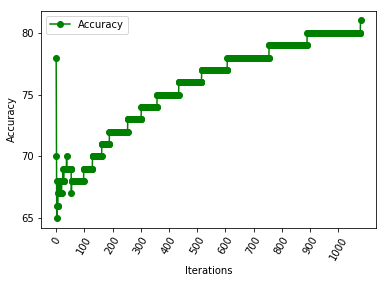

In [62]:
plt.xlabel("Iterations")
plt.ylabel("Accuracy")
plt.yticks(np.arange(0, 100, step=5))
plt.plot(train_stats.precs, 'go-', label='Accuracy')
plt.legend()
plt.xticks(np.arange(0, len(train_stats.precs), step=100), rotation=60)
plt.savefig('onecycle_acc.jpg')

Epochs vs Loss:

In [0]:
ep_losses = []
for i in range(0, len(train_stats.losses), len(learn.data.train_dl)):
    if i != 0 :
        ep_losses.append(train_stats.losses[i])
        
ep_lossesv = []
for i in range(0, len(test_stats.losses), len(learn.data.valid_dl)):
    if(i != 0):
        ep_lossesv.append(test_stats.losses[i])

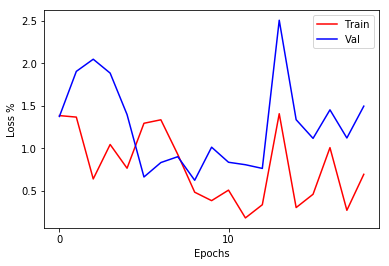

In [56]:
plt.xlabel("Epochs")
plt.ylabel("Loss %")
plt.xticks(np.arange(0, 1000, step=10))
plt.plot(ep_losses, 'r', label='Train')
plt.plot(ep_lossesv, 'b', label='Val')
plt.legend()
plt.savefig('onecycle_loss.jpg')

Iterations vs Learning Rate:

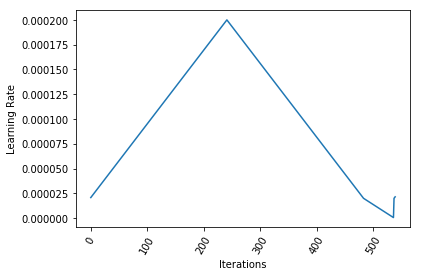

In [61]:
plt.xlabel("Iterations")
plt.ylabel("Learning Rate")
plt.xticks(np.arange(0, len(onecycle.lrs), step=100), rotation=60)
plt.plot(onecycle.lrs)
plt.savefig('onecycle_lr.jpg')

Iterations vs Momentum:

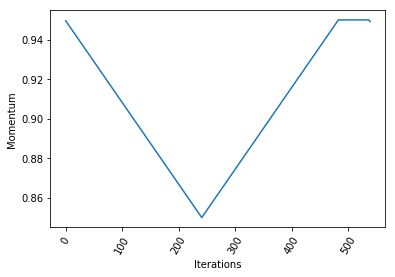

In [64]:
plt.xlabel("Iterations")
plt.ylabel("Momentum")
plt.xticks(np.arange(0, len(onecycle.moms), step=100), rotation=60)
plt.plot(onecycle.moms)
plt.savefig('onecycle_mom.jpg')